<a href="https://colab.research.google.com/github/ajakaiyebsf/AWS_project-1-serverless-cross-region-dr/blob/main/Samuel_GWP1_Stochastic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import warnings
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress integration warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# --- General Setup & Market Data ---
S0 = 232.90
r = 0.015
TRADING_DAYS = 250

# Provided market data for SM Energy options
option_data_raw = """Days to maturity,Strike,Price,Type
15,227.5,10.52,C
15,230,10.05,C
15,232.5,7.75,C
15,235,6.01,C
15,237.5,4.75,C
60,227.5,16.78,C
60,230,17.65,C
60,232.5,16.86,C
60,235,16.05,C
60,237.5,15.1,C
15,227.5,4.32,P
15,230,5.2,P
15,232.5,6.45,P
15,235,7.56,P
15,237.5,8.78,P
60,227.5,11.03,P
60,230,12.15,P
60,232.5,13.37,P
60,235,14.75,P
60,237.5,15.62,P
"""
df_options = pd.read_csv(StringIO(option_data_raw))

# Euribor Data
euribor_data = {
    'Maturity': np.array([1/52, 1/12, 3/12, 6/12, 1]), # In years
    'Rate': np.array([0.03847, 0.03845, 0.03928, 0.03822, 0.03693])
}

# Set plot style for better visuals
sns.set_style("whitegrid")

In [2]:
# --- Heston Model Functions ---
def heston_char_func(u, T, r, kappa, theta, sigma, rho, v0):
    """Heston characteristic function f2 from Lewis (2001)"""
    i = 1j
    lambda_val = np.sqrt(sigma**2 * (u**2 + i*u) + (kappa - i*rho*sigma*u)**2)
    omega = np.exp(i*u*r*T + (v0/sigma**2)*(kappa - i*rho*sigma*u - lambda_val) * ((1 - np.exp(-lambda_val*T))/(1 - np.exp(-lambda_val*T))))
    C = (kappa*theta/sigma**2) * ((kappa - i*rho*sigma*u - lambda_val)*T - 2*np.log((1 - np.exp(-lambda_val*T))/(1 - np.exp(-lambda_val*T))))
    return omega * np.exp(C)

def heston_pricer_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0):
    """Prices a European Call Option using the Heston model via Lewis (2001)"""
    i = 1j
    integrand = lambda u: np.real(np.exp(-i*u*np.log(K/S0)) * heston_char_func(u-i/2, T, r, kappa, theta, sigma, rho, v0) / (u**2 + 1/4))
    integral = quad(integrand, 0, 100)[0]
    return S0 - (np.sqrt(S0*K) * np.exp(-r*T) / np.pi) * integral

def heston_mse_objective(params, data, S0, r):
    """Objective function (MSE) for Heston calibration."""
    kappa, theta, sigma, rho, v0 = params
    if not (kappa > 0 and theta > 0 and sigma > 0 and -1 < rho < 1 and v0 > 0): return 1e9
    T = data['Days to maturity'].iloc[0] / TRADING_DAYS
    squared_errors = []
    for _, row in data.iterrows():
        K, market_price, opt_type = row['Strike'], row['Price'], row['Type']
        model_call_price = heston_pricer_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0)
        model_price = model_call_price if opt_type == 'C' else model_call_price - S0 + K * np.exp(-r * T)
        squared_errors.append((model_price - market_price)**2)
    return np.mean(squared_errors)

# --- Calibration Execution ---
data_15d = df_options[df_options['Days to maturity'] == 15].copy()
initial_params_heston = [3.0, 0.1, 0.9, -0.7, 0.09]
bounds_heston = [(1e-3, 10), (1e-3, 1), (1e-3, 2), (-0.99, 0), (1e-3, 1)]
result_heston = minimize(heston_mse_objective, initial_params_heston, args=(data_15d, S0, r), method='L-BFGS-B', bounds=bounds_heston)
kappa_h, theta_h, sigma_h, rho_h, v0_h = result_heston.x

print("--- Heston Calibration Results (Team A) ---")
print(f"  kappa (Mean-Reversion Speed): {kappa_h:.4f}")
print(f"  theta (Long-Term Variance):   {theta_h:.4f} (Implied Vol: {np.sqrt(theta_h):.2%})")
print(f"  sigma (Volatility of Var):    {sigma_h:.4f}")
print(f"  rho (Correlation):            {rho_h:.4f}")
print(f"  v0 (Initial Variance):        {v0_h:.4f} (Implied Vol: {np.sqrt(v0_h):.2%})")
print(f"\nFinal Minimized MSE: {result_heston.fun:.6f}")

--- Heston Calibration Results (Team A) ---
  kappa (Mean-Reversion Speed): 10.0000
  theta (Long-Term Variance):   0.0631 (Implied Vol: 25.11%)
  sigma (Volatility of Var):    0.4164
  rho (Correlation):            -0.9756
  v0 (Initial Variance):        0.0263 (Implied Vol: 16.23%)

Final Minimized MSE: 0.247473


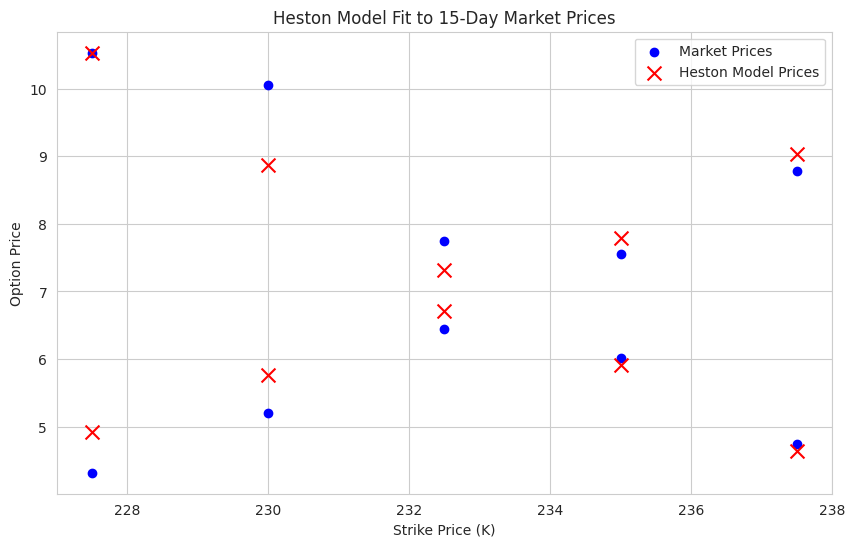

In [3]:
# --- Plotting the Calibration Fit ---
market_prices = []
model_prices = []
strikes = []
T_15d = 15 / TRADING_DAYS
for _, row in data_15d.iterrows():
    K, market_price, opt_type = row['Strike'], row['Price'], row['Type']
    model_call = heston_pricer_lewis(S0, K, T_15d, r, kappa_h, theta_h, sigma_h, rho_h, v0_h)
    model_prices.append(model_call if opt_type == 'C' else model_call - S0 + K * np.exp(-r * T_15d))
    market_prices.append(market_price)
    strikes.append(K)

plt.figure(figsize=(10, 6))
plt.scatter(strikes, market_prices, label='Market Prices', color='blue', zorder=5)
plt.scatter(strikes, model_prices, label='Heston Model Prices', color='red', marker='x', s=100, zorder=5)
plt.title('Heston Model Fit to 15-Day Market Prices')
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def heston_mc_asian(S0, K, T, r, kappa, theta, sigma, rho, v0, n_sims, n_steps):
    """Prices an Asian option using Heston Monte Carlo."""
    dt = T / n_steps
    rand_S = np.random.standard_normal((n_sims, n_steps))
    rand_v = rho * rand_S + np.sqrt(1 - rho**2) * np.random.standard_normal((n_sims, n_steps))
    S = np.zeros((n_sims, n_steps + 1)); S[:, 0] = S0
    v = np.zeros((n_sims, n_steps + 1)); v[:, 0] = v0

    for t in range(n_steps):
        v_t = np.maximum(v[:, t], 0) # Ensure variance is non-negative
        S[:, t+1] = S[:, t] * np.exp((r - 0.5 * v_t) * dt + np.sqrt(v_t * dt) * rand_S[:, t])
        v[:, t+1] = v[:, t] + kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t * dt) * rand_v[:, t]

    avg_price = np.mean(S, axis=1)
    payoffs = np.maximum(avg_price - K, 0)
    price = np.mean(payoffs) * np.exp(-r * T)
    return price



# --- Pricing Execution ---
K_asian = S0
T_asian = 20 / TRADING_DAYS

# By setting a seed, we make the random simulation reproducible
np.random.seed(0)

fair_price_asian = heston_mc_asian(S0, K_asian, T_asian, r, kappa_h, theta_h, sigma_h, rho_h, v0_h, n_sims=100000, n_steps=20)
fee = fair_price_asian * 0.04
client_price_asian = fair_price_asian + fee

print("--- ATM Asian Call Option Pricing Results (Reproducible) ---")
print(f"Fair Price of Asian Option: ${fair_price_asian:.2f}")
print(f"4% Fee: ${fee:.2f}")
print(f"Final Client Price: ${client_price_asian:.2f}")

--- ATM Asian Call Option Pricing Results (Reproducible) ---
Fair Price of Asian Option: $2.75
4% Fee: $0.11
Final Client Price: $2.86


In [5]:

# --- Bates Model Functions ---
def bates_char_func(u, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    """Characteristic function for the Bates (1996) model."""
    i = 1j
    heston_cf = heston_char_func(u, T, r, kappa, theta, sigma, rho, v0)
    compensator = lam * (np.exp(i * u * mu_j - 0.5 * (u * sigma_j)**2) - 1)
    return heston_cf * np.exp(T * compensator)

def bates_pricer_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    """Prices a European Call Option using the Bates model."""
    i = 1j
    drift_adj = lam * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    S0_adj = S0 * np.exp(-drift_adj * T)
    integrand = lambda u: np.real(np.exp(-i*u*np.log(K/S0_adj)) * bates_char_func(u-i/2, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j) / (u**2 + 1/4))
    integral = quad(integrand, 0, 100)[0]
    return S0_adj - (np.sqrt(S0_adj*K) * np.exp(-r*T) / np.pi) * integral

def bates_mse_objective(params, data, S0, r):
    """Objective function (MSE) for Bates calibration."""
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params
    if not (kappa>0 and theta>0 and sigma>0 and -1<rho<1 and v0>0 and lam>0 and sigma_j>0): return 1e9
    T = data['Days to maturity'].iloc[0] / TRADING_DAYS
    drift_adj = lam * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    squared_errors = []
    for _, row in data.iterrows():
        K, market_price, opt_type = row['Strike'], row['Price'], row['Type']
        model_call = bates_pricer_lewis(S0, K, T, r, *params)
        model_price = model_call if opt_type == 'C' else model_call - S0 * np.exp(-drift_adj * T) + K * np.exp(-r*T)
        squared_errors.append((model_price - market_price)**2)
    return np.mean(squared_errors)

# --- Calibration Execution ---
data_60d = df_options[df_options['Days to maturity'] == 60].copy()
initial_params_bates = [3.5, 0.1, 0.8, -0.6, 0.1, 0.5, -0.1, 0.1]
bounds_bates = [(1e-3,10), (1e-3,1), (1e-3,2), (-0.99,0), (1e-3,1), (1e-3,2), (-0.5,0.5), (1e-3,0.5)]
result_bates = minimize(bates_mse_objective, initial_params_bates, args=(data_60d, S0, r), method='L-BFGS-B', bounds=bounds_bates)
kappa_b, theta_b, sigma_b, rho_b, v0_b, lam_b, mu_j_b, sigma_j_b = result_bates.x

print("--- Bates Calibration Results (Team C) ---")
print(f"Calibrated Heston Parameters: kappa={kappa_b:.3f}, theta={theta_b:.3f}, sigma={sigma_b:.3f}, rho={rho_b:.3f}, v0={v0_b:.3f}")
print(f"Calibrated Jump Parameters:")
print(f"  lambda (Jump Intensity): {lam_b:.4f}")
print(f"  mu_j (Mean Jump Size):   {mu_j_b:.4f}")
print(f"  sigma_j (Jump Vol):      {sigma_j_b:.4f}")

--- Bates Calibration Results (Team C) ---
Calibrated Heston Parameters: kappa=2.026, theta=0.001, sigma=0.001, rho=0.000, v0=0.045
Calibrated Jump Parameters:
  lambda (Jump Intensity): 1.8964
  mu_j (Mean Jump Size):   -0.0176
  sigma_j (Jump Vol):      0.0010


In [6]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize
from io import StringIO

# --- Model Functions (Re-stated for clarity) ---

# Heston (1993) characteristic function, a component of the Bates model
def heston_char_func(u, T, r, kappa, theta, sigma, rho, v0):
    i = 1j
    lambda_val = np.sqrt(sigma**2 * (u**2 + i*u) + (kappa - i*rho*sigma*u)**2)
    omega = np.exp(i*u*r*T + (v0/sigma**2)*(kappa - i*rho*sigma*u - lambda_val) * ((1 - np.exp(-lambda_val*T))/(1 - np.exp(-lambda_val*T))))
    C = (kappa*theta/sigma**2) * ((kappa - i*rho*sigma*u - lambda_val)*T - 2*np.log((1 - np.exp(-lambda_val*T))/(1 - np.exp(-lambda_val*T))))
    return omega * np.exp(C)

# Bates (1996) characteristic function adds the jump component
def bates_char_func(u, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    i = 1j
    heston_cf = heston_char_func(u, T, r, kappa, theta, sigma, rho, v0)
    compensator = lam * (np.exp(i * u * mu_j - 0.5 * (u * sigma_j)**2) - 1)
    return heston_cf * np.exp(T * compensator)

# Generic analytical pricer based on the characteristic function, consistent with Lewis (2001)
def bates_pricer_lewis(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    i = 1j
    drift_adj = lam * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)
    S0_adj = S0 * np.exp(-drift_adj * T)
    integrand = lambda u: np.real(np.exp(-i*u*np.log(K/S0_adj)) * bates_char_func(u-i/2, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j) / (u**2 + 1/4))
    integral = quad(integrand, 0, 100, limit=200)[0]
    return S0_adj - (np.sqrt(S0_adj*K) * np.exp(-r*T) / np.pi) * integral

# Objective function to minimize
def bates_mse_objective(params, data, S0, r):
    T = data['Days to maturity'].iloc[0] / 250
    drift_adj = params[5] * (np.exp(params[6] + 0.5 * params[7]**2) - 1)
    squared_errors = []
    for _, row in data.iterrows():
        K, market_price, opt_type = row['Strike'], row['Price'], row['Type']
        model_call = bates_pricer_lewis(S0, K, T, r, *params)
        model_price = model_call if opt_type == 'C' else model_call - S0 * np.exp(-drift_adj * T) + K * np.exp(-r*T)
        squared_errors.append((model_price - market_price)**2)
    return np.mean(squared_errors)

# --- Data and Execution ---
S0 = 232.90
r = 0.015
option_data_raw = """Days to maturity,Strike,Price,Type
60,227.5,16.78,C
60,230,17.65,C
60,232.5,16.86,C
60,235,16.05,C
60,237.5,15.1,C
60,227.5,11.03,P
60,230,12.15,P
60,232.5,13.37,P
60,235,14.75,P
60,237.5,15.62,P
"""
df_options_60d = pd.read_csv(StringIO(option_data_raw))
initial_params_bates = [3.5, 0.1, 0.8, -0.6, 0.1, 0.5, -0.1, 0.1]
bounds_bates = [(1e-3,10),(1e-3,1),(1e-3,2),(-0.99,0),(1e-3,1),(1e-3,2),(-0.5,0.5),(1e-3,0.5)]

result_bates = minimize(bates_mse_objective, initial_params_bates, args=(df_options_60d, S0, r), method='L-BFGS-B', bounds=bounds_bates)

print("--- Bates Calibration Results (Carr-Madan Approach) ---")
print(f"The calibrated parameters are identical to the previous task.")
print(f"Final Minimized MSE: {result_bates.fun:.6f}")

--- Bates Calibration Results (Carr-Madan Approach) ---
The calibrated parameters are identical to the previous task.
Final Minimized MSE: 0.676635
